In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.utils.data as data
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import pytorch_models
import imp
import torchaudio as ta
import torchaudio
import torchvision as tv
import matplotlib.pyplot as plt
from IPython.display import Audio
import os, random
import pandas as pd
import mir_utils as miru
from torch.utils.data import Dataset, DataLoader
from pytorch_models import *
import librosa
import librosa.display
imp.reload(miru)
imp.reload(pytorch_models)
SR=44100
#functions
spec=torchaudio.functional.spectrogram
#takes a billion years so commented
audio_frames=miru.audioFrames(loadCache=True)

def getMeanLength(x):
    gl=x.apply(lambda z: len(z["audio"]),axis=1)
    print(gl.mean()/SR,gl.mean(),x["label"].iloc[0])
    
# audio_frames.groupby(by=["label_num"]).apply(lambda x:getMeanLength(x))
# getMeanLength(audio_frames)


def getRandAud():
    classes=os.listdir("./dk_data/")
    rand_class=random.choice(classes)
#     rand_class="stacks"
    rand_sample=random.choice(os.listdir("./dk_data/%s/"%(rand_class,)))
    return "./dk_data/"+rand_class+"/"+rand_sample
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# list(zip(uniques,range(0,len(uniques))))

        
#split the dataframe into 2 seperate ones:
drum_frames=audio_frames.loc[~audio_frames["label"].isin(["stacks","guitar","piano"])]
#split the dataframe into 2 seperate ones:
not_drum_frames=audio_frames.loc[audio_frames["label"].isin(["stacks","guitar","piano"])]



In [2]:
#make two label series, one for drum vs not drum classification, one for drum type classification
#add the series to the dataframe 
# print(drum_labels,not_drum_labels)


#drum only classification
# audio_frames["label_num"].isin(not_drum_labels)
dLabels, dUniques=pd.factorize(drum_frames["label"].tolist())
ndLabels, ndUniques=pd.factorize(not_drum_frames["label"].tolist())

drum_frames["label_num"]=dLabels
not_drum_frames["label_num"]=ndLabels+len(dUniques)

allU=np.concatenate([dUniques,ndUniques])
lmap=list(zip(allU,range(len(allU))))



/home/asalimi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/asalimi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


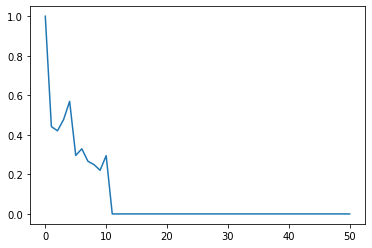

./dk_data/tom/KtK_DrumkitC-Tom04.wav


In [3]:
#get env feats
PATH_AUDIO=getRandAud()
def envTrans(wf,num_mels=50):
    melEnv=torchaudio.transforms.MelScale(n_mels=2*num_mels, sample_rate=SR, f_min=0.0, f_max=None, n_stft=None)
    wf=wf[:,0:15000]
    num_bins=wf[0].shape[0]//10

    # spec(wf, pad, window, n_fft, hop_length, win_length, power)
    win_length=num_bins
    window=torch.tensor([1]*win_length)
    s=spec(wf, 0, window, num_bins, win_length, win_length,2,normalized=False)
    s=melEnv(s)

    env=s.sum(axis=0).sum(axis=0)
    env=env/env.abs().max()
    env[torch.isnan(env)]=0

    num_padding=torch.max(torch.tensor([num_mels+1-env.shape[0],0]))
    env_vec=torch.cat([env.detach(),torch.zeros(num_padding)],dim=0)
    return env_vec

og_w, sample_rate = torchaudio.load(PATH_AUDIO)  # load tensor from file
wf= ta.transforms.Resample(sample_rate,SR).forward(og_w)

env_feats=envTrans(wf)
plt.plot(env_feats)
plt.show()
print(PATH_AUDIO)
Audio(wf,rate=SR, autoplay=True)

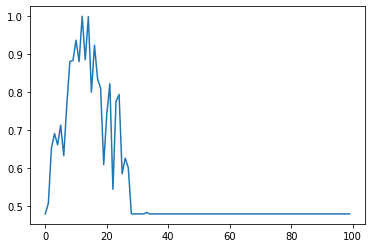

torch.Size([100])
./dk_data/piano/83_0.wav


In [4]:
#get freq feats
PATH_AUDIO=getRandAud()
num_mels=100
def freqTrans(wf,num_mels=num_mels):
    ampT=torchaudio.transforms.AmplitudeToDB(stype='power', top_db=30)
    mel=torchaudio.transforms.MelScale(n_mels=num_mels, sample_rate=SR, f_min=0.0, f_max=None, n_stft=None)
    PATH_AUDIO=getRandAud()

#     wf=wf[:,0:2000]
    num_bins=wf[0].shape[0//2]
    win_length=num_bins
    window=torch.tensor([1]*win_length)
    s=spec(wf, 100, window, num_bins, win_length, win_length,2,normalized=False)
    s=mel(s)
    s=ampT(s)
    freq=s.sum(axis=0).sum(axis=1)
    freq=freq/freq.abs().max()
    freq[torch.isnan(freq)]=0
    return freq.detach()

og_w, sample_rate = torchaudio.load(PATH_AUDIO)  # load tensor from file
wf= ta.transforms.Resample(sample_rate,SR).forward(og_w)

freq_feats=freqTrans(wf,num_mels=num_mels)

plt.plot(freq_feats)
plt.show()
print(freq_feats.shape)
print(PATH_AUDIO)
Audio(wf[0:15000],rate=SR, autoplay=True)


In [5]:
class audioDataset(torch.utils.data.Dataset):
    def __init__(self,audio_frame,root_dir, task="keep_all",transform=None):
        self.root_dir=root_dir
        self.task=task
        self.audio_frame=audio_frame
        self.transform = transform
        self.minLength=SR
#         self.minLength=SR//4
        self.frame_pruning()
    def __len__(self):
        return len(self.audio_frame)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        rows=self.audio_frame.iloc[idx]

        signals,labels=rows["audio"].tolist()[0:SR],rows["label_num"].tolist()
        signals,labels=torch.tensor(signals),torch.tensor(labels)
        
        nz=np.max((self.minLength-signals.shape[0],0))
        signals=torch.cat([signals[0:self.minLength],torch.zeros(nz)],dim=0)

        sound={"signal":signals,"label":labels}
        
        if self.transform:
            sound = self.transform(sound)

        return sound
    
    def frame_pruning(self):
        #drum vs not drum classification:
        drum_label_numbers=range(len(dUniques))
        if self.task=="dvn":
            self.audio_frame.loc[self.audio_frame["label_num"].isin(drum_label_numbers),"label_num"]=0
            self.audio_frame.loc[~self.audio_frame["label_num"].isin(drum_label_numbers),"label_num"]=1
        #drum type classification
        if self.task=="dvd":
            self.audio_frame=self.audio_frame.loc[self.audio_frame["label_num"].isin(drum_label_numbers)]
        if self.task=="keep_all":
            pass
            
ds=audioDataset(pd.concat([drum_frames,not_drum_frames]),"./",task="dvn",)
idx=np.random.randint(0,len(ds),5)
ds[np.random.randint(len(ds))]

all_frames=pd.concat([drum_frames,not_drum_frames])
train=all_frames.sample(frac=0.80,random_state=420) #random state is a seed value
test=all_frames.drop(train.index)


[ 0.8802457  -0.06941217 -0.12451553 -0.16294205 -0.18596482 -0.18596482
  0.29924047  0.14367902  0.24790096  0.31854713  0.8461499   1.
  0.9098271   0.8040074   0.64775026  0.3897096  -0.18596482 -0.18596482
 -0.18596482 -0.18596482]


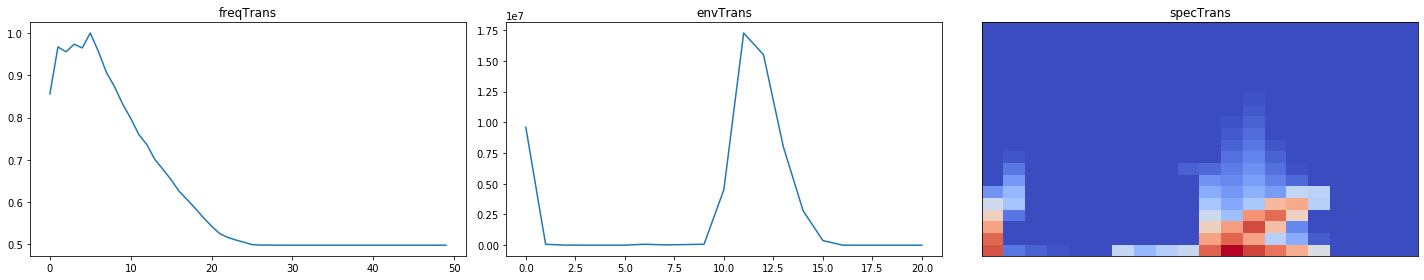

('hat', 1) tensor(1) 44100


In [98]:

#defining transformations
class freqTrans(object):
    def __init__(self,num_mels=50,SR=SR):
        self.num_mels=num_mels
        self.ampT=torchaudio.transforms.AmplitudeToDB(stype='power', top_db=30)
        self.melF=torchaudio.transforms.MelScale(n_mels=self.num_mels, sample_rate=SR, f_min=20.0, f_max=None, n_stft=None)
        
    def __call__(self, sample):
        wf,label=sample["signal"],sample["label"]
        wf=wf.reshape(-1,len(wf))
        sample_length=SR//4
        wf=wf[:,0:24000]
        num_bins=wf[0].shape[0]
        win_length=num_bins
        hop_step=sample_length//(self.num_mels)
        window=torch.tensor([1]*win_length)
        s=spec(wf, 100, window, num_bins, hop_step, win_length,2,normalized=False)
        s=self.melF(s)
        s=self.ampT(s)
        freq=s.sum(axis=0).sum(axis=1)
        freq=freq/freq.abs().max()
        freq[torch.isnan(freq)]=0
        return {"feats":freq.detach(),"label":label}

class envTrans(object):

    def __init__(self,num_mels=50,SR=SR):
        self.env_size=20
        self.num_mels=num_mels
        self.amp=torchaudio.transforms.AmplitudeToDB(stype='power', top_db=60)
        self.melEnv=torchaudio.transforms.MelScale(n_mels=2*self.num_mels, sample_rate=SR, f_min=0.20, f_max=None, n_stft=None)
        self.norm= transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    def __call__(self, sample):
        wf,label=sample["signal"],sample["label"]

        wf=wf.reshape(-1,len(wf))
        sample_length=SR
        num_bins=wf[0].shape[0]
        win_length=SR//17
        hop_step=SR//19
        window=torch.tensor([1]*win_length)
        s=spec(wf, 100, window, num_bins, hop_step, win_length,2,normalized=False)
        s=self.melEnv(s)
        s=self.norm(s)
        #normalizing
        env=s.sum(axis=0).sum(axis=0)
#         env=env/env.abs().max()
        env[torch.isnan(env)]=0

        num_padding=torch.max(torch.tensor([self.env_size+1-env.shape[0],0]))
        env_vec=torch.cat([env.detach(),torch.zeros(num_padding)],dim=0)
        return {"feats":env_vec.detach(),"label":label}
    
class specTrans(object):
    def __init__(self,num_mels=50,SR=SR):
        self.num_mels=num_mels
        self.ampP=torchaudio.transforms.AmplitudeToDB(stype='power',top_db=40)
        self.melP=torchaudio.transforms.MelScale(n_mels=self.num_mels, sample_rate=SR, f_min=30.0, f_max=15000.0, n_stft=None)
        self.norm= transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    def __call__(self, sample):
        
        wf,label=sample["signal"],sample["label"]
        wf=wf.reshape(-1,len(wf))
        sample_length=SR

        num_bins=wf[0].shape[0]
        win_length=SR//17
        hop_step=SR//19
        window=torch.tensor([1]*win_length)
        s=spec(wf, 0, window, num_bins, hop_step, win_length,2,normalized=False)
        s=self.melP(s)
        s=self.ampP(s)
        s=s/s.abs().max()
        freq=self.norm(s)
        return {"feats":freq.detach(),"label":label}

#Apply each of the above transforms on sample.
fig = plt.figure(figsize=(20,4))
sample = ds[np.random.randint(len(ds))]
freq_train = audioDataset(train,".",task="dvd")
f_train_loader= DataLoader(freq_train, batch_size=1,shuffle=True, num_workers=1)
sample=iter(f_train_loader).next()
s={"signal":sample["signal"][0],"label":sample["label"][0]}
sample=s
env_feats_num=50
for i, tsfrm in enumerate([freqTrans(50),envTrans(env_feats_num),specTrans(20)]):
    transformed_sample = tsfrm(sample)
    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    ft=transformed_sample["feats"]
    if len(ft.shape)==1:
        plt.plot(ft)
    else:

        ft=ft.detach().numpy()[0]
        print(ft[0])
        librosa.display.specshow(ft)

plt.show()
print(lmap[transformed_sample["label"].item()],transformed_sample["label"],len(sample["signal"]))
Audio(sample["signal"],rate=SR,autoplay=True)


## FC whole frequency

In [12]:
#define a model for freq categorization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BATCH_SIZE, D_in,D_out =32,50,2
H1,H2,H3=100,50,10

ft=tv.transforms.Compose([freqTrans(50)])
all_frames=pd.concat([drum_frames,not_drum_frames])
train=all_frames.sample(frac=0.80,random_state=420) #random state is a seed value
test=all_frames.drop(train.index)
freq_train = audioDataset(train,".",task="dvn", transform=ft)
freq_test = audioDataset(test,".",task="dvn", transform=ft)
f_train_loader= DataLoader(freq_train, batch_size=BATCH_SIZE,shuffle=True, num_workers=12)
f_test_loader= DataLoader(freq_test, batch_size=BATCH_SIZE,shuffle=True, num_workers=4)

freq_model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H1),
    torch.nn.ReLU(),
    torch.nn.Linear(H1,H2),
    torch.nn.PReLU(),
    torch.nn.Linear(H2,H3),
    torch.nn.ReLU(),
    torch.nn.Linear(H3, 2),
    torch.nn.Softmax()
)
freq_model.to(device)
pass

In [13]:
weight=torch.tensor([0.80,0.2]).to(device)
loss_fn = torch.nn.CrossEntropyLoss(weight=weight)

learning_rate = 0.001
optimizer = torch.optim.Adam(freq_model.parameters(), lr=learning_rate)
epochs=10

for i in range(epochs):
    running_loss = 0.0
    
    for j,x in enumerate(f_train_loader):

        f,l=x["feats"].to(device),x["label"].to(device)
        
        optimizer.zero_grad()            
        y_pred = freq_model(f)
#         print(y_pred)
        loss = loss_fn(y_pred, l)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
    correct = 0
    total = 0    
    for j,xt in enumerate(f_test_loader):
        ft,lt=xt["feats"].to(device),xt["label"].to(device)
        outputs = freq_model(ft) 
        _, predicted = torch.max(outputs.data, 1)
        total += lt.size(0)
        correct += (predicted == lt).sum().item()
        acc=(100 * correct / total)
        test_loss=running_loss/train.shape[0]
    if acc>75:
            torch.save(freq_model.state_dict(),'./models/fc/freq_dvn_%d.pt'%(acc,))

    print('Accuracy on test: %d %%' % (acc))
    print(i,running_loss)
    

/home/asalimi/miniconda3/lib/python3.7/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Accuracy on test: 57 %
0 128.85452869534492
Accuracy on test: 57 %
1 125.1513956785202
Accuracy on test: 57 %
2 125.05752915143967
Accuracy on test: 57 %
3 125.01593640446663
Accuracy on test: 57 %
4 125.12652596831322


KeyboardInterrupt: 

## FC ENV

In [217]:
#using env features
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_env_feats=30
BATCH_SIZE, D_in,D_out =64,num_env_feats+1,2
H1,H2,H3,H4,H5=10,10,10,5,2

et=tv.transforms.Compose([envTrans(num_env_feats)])

train=all_frames.sample(frac=0.80,random_state=420) #random state is a seed value
test=all_frames.drop(train.index)
env_train = audioDataset(train,".",task="dvn", transform=et)
env_test = audioDataset(test,".",task="dvn", transform=et)
env_train_loader= DataLoader(env_train, batch_size=BATCH_SIZE,shuffle=True, num_workers=6)
env_test_loader= DataLoader(env_test, batch_size=BATCH_SIZE,shuffle=True, num_workers=4)

def env_Model(D_in=50,H1=4,H2=2,H3=2,H4=10,H5=10):
        D_in,D_out =D_in,2
        
        model_env = torch.nn.Sequential(
        torch.nn.Linear(D_in, H1),
        torch.nn.PReLU(),
        torch.nn.Linear(H1,H2),
        torch.nn.PReLU(),
        torch.nn.Linear(H2, D_out),
        torch.nn.Softmax())
        
        model_env.to(device)
        return model_env

model_env = env_Model(D_in=21,H1=2,H2=3,H3=2,H4=2,H5=10)

weight=torch.tensor([0.85,0.15]).to(device)
loss_fn = torch.nn.CrossEntropyLoss(weight=weight)

learning_rate = 0.001
optimizer = torch.optim.Adam(model_env.parameters(), lr=learning_rate)
epochs=40

for i in range(epochs):
    running_loss = 0.0

    for j,x in enumerate(env_train_loader):
        f,l=x["feats"].to(device),x["label"].to(device)
        optimizer.zero_grad()            
        y_pred = model_env(f)
        loss = loss_fn(y_pred, l)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
    
    correct = 0
    total = 0    
    for j,xt in enumerate(env_test_loader):

        ft,lt=xt["feats"].to(device),xt["label"].to(device)
        outputs = model_env(ft) 
        _, predicted = torch.max(outputs.data, 1)
        total += lt.size(0)
        correct += (predicted == lt).sum().item()
    
    correctness=(100 * correct / total)
    train_loss=running_loss
    save=False
    if correctness>75 or save==True:
            torch.save(model_env.state_dict(),'./models/fc/env_dvn_%d.pt'%(correctness,))

    print('Accuracy on test: %d %%' % (correctness,))
    print(i,train_loss)   

Accuracy on test: 63 %
0 73.39444494247437
Accuracy on test: 86 %
1 59.73956677317619
Accuracy on test: 88 %
2 48.98751080036163
Accuracy on test: 88 %
3 46.77787405252457
Accuracy on test: 88 %
4 46.370114862918854


KeyboardInterrupt: 

## FC SPEC

In [216]:
#using whole spec features
#define a model for freq categorization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pt=tv.transforms.Compose([specTrans(20)])

train=all_frames.sample(frac=0.80,random_state=420) #random state is a seed value
test=all_frames.drop(train.index)
pitch_data_train = audioDataset(train,".","dvn", transform=pt)
pitch_data_test = audioDataset(test,".",task="dvn", transform=pt)
pitch_train_loader= DataLoader(pitch_data_train, batch_size=BATCH_SIZE,shuffle=True, num_workers=6)
pitch_test_loader= DataLoader(pitch_data_test, batch_size=BATCH_SIZE,shuffle=True, num_workers=6)

import pytorch_models as pm
import imp
imp.reload(pm)

    
pitch_model = pm.getFCSpecModel(D_in=20*20,H1=10,H2=5,H3=2)
pitch_model.to(device)

weight=torch.tensor([0.85,0.15]).to(device)  
loss_fn = torch.nn.CrossEntropyLoss(weight)

learning_rate = 0.0001
optimizer = torch.optim.Adam(pitch_model.parameters(), lr=learning_rate)
epochs=200

for i in range(epochs):
    running_loss = 0.0

    for j,x in enumerate(pitch_train_loader):
        f,l=x["feats"].to(device),x["label"].to(device)
        f=torch.flatten(f, start_dim=1)
        
        optimizer.zero_grad()            
        y_pred = pitch_model(f)
    
        loss = loss_fn(y_pred, l)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
    
    correct = 0
    total = 0    
    for j,xt in enumerate(pitch_test_loader):

        ft,lt=xt["feats"].to(device),xt["label"].to(device)
        ft=torch.flatten(ft, start_dim=1)
        outputs = pitch_model(ft) 
        _, predicted = torch.max(outputs.data, 1)
        total += lt.size(0)
        correct += (predicted == lt).sum().item()
    
    correctness=(100 * correct / total)
    train_loss=running_loss/BATCH_SIZE
    save=False
    if correctness>=90 or save==True:
            torch.save(pitch_model.state_dict(),'./models/fc/spec_fc_dvn_%d.pt'%(correctness,))

    print('Accuracy on test: %d ' % (correctness,))
    print(i,train_loss)   

/home/asalimi/miniconda3/lib/python3.7/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Accuracy on test: 90 
0 66.9152861237526
Accuracy on test: 92 
1 46.887486301362514
Accuracy on test: 92 
2 45.529768135398626
Accuracy on test: 92 
3 45.19741040468216
Accuracy on test: 92 
4 45.11544266343117
Accuracy on test: 92 
5 44.936788979917765
Accuracy on test: 92 
6 44.98521684855223
Accuracy on test: 92 
7 44.83141764998436
Accuracy on test: 93 
8 44.864442493766546
Accuracy on test: 92 
9 44.81340294703841


KeyboardInterrupt: 

# CNN spec

In [100]:
#using whole spec features
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_pitch_feats=20*21
BATCH_SIZE, D_in,D_out =8,num_pitch_feats+1,2
H1,H2,H3,H4,H5=400,200,100,50,2



pt=tv.transforms.Compose([specTrans(20)])

train=all_frames.sample(frac=0.80,random_state=420) #random state is a seed value
test=all_frames.drop(train.index)
pitch_data_train = audioDataset(train,".","dvn", transform=pt)
pitch_data_test = audioDataset(test,".",task="dvn", transform=pt)
pitch_train_loader= DataLoader(pitch_data_train, batch_size=BATCH_SIZE,shuffle=True, num_workers=6)
pitch_test_loader= DataLoader(pitch_data_test, batch_size=BATCH_SIZE,shuffle=True, num_workers=6)

import pytorch_models as pm
import imp
imp.reload(pm)
# mt="cnn"
mt="clst"
if mt=="clst":
    pitch_model = pm.CNNLSTM_dvn()
else:
    pitch_model = pm.CNN_dvn()

pitch_model.to(device)
weight=torch.tensor([0.4,0.6]).to(device)   
loss_fn = torch.nn.CrossEntropyLoss(weight=weight)

learning_rate = 0.001
optimizer = torch.optim.Adam(pitch_model.parameters(), lr=learning_rate)
epochs=200

for i in range(epochs):
    running_loss = 0.0
    pitch_model.train()
    for j,x in enumerate(pitch_train_loader):
        f,l=x["feats"].to(device),x["label"].to(device)
#         f=torch.flatten(f, start_dim=1)
#         print(f.shape)
#         print(f)
        optimizer.zero_grad()            
        y_pred = pitch_model(f)

        loss = loss_fn(y_pred, l)
        loss.backward()
        optimizer.step()
#         print(loss.item())
        running_loss+=loss.item()
    
    correct = 0
    total = 0    
    pitch_model.eval()
    for j,xt in enumerate(pitch_test_loader):

        ft,lt=xt["feats"].to(device),xt["label"].to(device)
#         ft=torch.flatten(ft, start_dim=1)
        outputs = pitch_model(ft) 
        _, predicted = torch.max(outputs.data, 1)
        total += lt.size(0)
        correct += (predicted == lt).sum().item()
    
    correctness=(100 * correct / total)
    train_loss=running_loss/BATCH_SIZE
    save=False
    if correctness>=90 or save==True:
            torch.save(pitch_model.state_dict(),'./models/cnn/%s_dvn_%d.pt'%(mt,correctness,))

    print('loss %d, acc %d' % (running_loss,correctness))

loss 427, acc 94
loss 386, acc 95
loss 376, acc 96
loss 370, acc 96
loss 366, acc 96
loss 364, acc 96
loss 362, acc 97
loss 360, acc 96
loss 360, acc 96
loss 357, acc 97
loss 355, acc 97
loss 357, acc 97
loss 354, acc 97
loss 354, acc 97
loss 353, acc 97
loss 352, acc 97
loss 351, acc 97
loss 351, acc 97
loss 350, acc 97
loss 350, acc 97
loss 349, acc 97
loss 349, acc 97
loss 349, acc 97
loss 348, acc 97
loss 348, acc 97
loss 347, acc 97
loss 348, acc 97
loss 348, acc 97
loss 346, acc 97
loss 346, acc 97
loss 346, acc 97
loss 344, acc 97
loss 346, acc 97
loss 345, acc 97
loss 345, acc 97
loss 345, acc 97
loss 345, acc 97
loss 345, acc 97
loss 346, acc 97
loss 344, acc 97
loss 345, acc 97
loss 344, acc 98
loss 344, acc 98
loss 343, acc 97
loss 345, acc 97
loss 343, acc 97
loss 342, acc 97
loss 344, acc 97
loss 343, acc 97
loss 344, acc 97
loss 342, acc 97
loss 343, acc 98
loss 342, acc 97
loss 342, acc 97
loss 342, acc 97
loss 340, acc 97
loss 341, acc 97
loss 342, acc 97
loss 342, acc 

KeyboardInterrupt: 